In [1]:
# backtestig works as expected but plotting is poor. 
# Results from backtrader are very close to custom computation suggesting it is correct

In [1]:
import os
import pandas as pd
import joblib
import backtrader as bt
import ml_investing_wne.config as config
from ml_investing_wne.helper import load_test_dates

In [2]:
start_date, end_date = load_test_dates()
print(start_date, end_date)

2021-01-15 12:00:00 2021-12-24 12:00:00


In [3]:
df = pd.read_csv(os.path.join(config.processed_data_path, config.currency,
                               'Backtest_{}_{}.csv'.format(config.freq, config.model)), parse_dates=['datetime'])

In [5]:
df.head(3)

,datetime,open,high,low,close,y_pred,change,prediction_1
0,2021-01-15 12:00:00,1.07610,1.07658,1.07570,1.07570,0.000781,0.000781,0.519121
1,2021-01-17 12:00:00,1.07576,1.07701,1.07531,1.07654,-0.000873,-0.000873,0.471611
2,2021-01-18 00:00:00,1.07655,1.07694,1.07388,1.07560,0.001748,0.001748,0.540796


In [6]:
df.set_index('datetime', inplace=True)

In [7]:
df.head(3)

,open,high,low,close,y_pred,change,prediction_1
datetime,,,,,,,
2021-01-15 12:00:00,1.07610,1.07658,1.07570,1.07570,0.000781,0.000781,0.519121
2021-01-17 12:00:00,1.07576,1.07701,1.07531,1.07654,-0.000873,-0.000873,0.471611
2021-01-18 00:00:00,1.07655,1.07694,1.07388,1.07560,0.001748,0.001748,0.540796


In [8]:
df.dtypes

open            float64
high            float64
low             float64
close           float64
y_pred          float64
change          float64
prediction_1    float64
dtype: object

In [22]:
# class to define the columns we will provide
class MyData(bt.feeds.PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume', 'prediction_1']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [23]:
data = MyData(dataname=df)

In [24]:
data

In [28]:
import itertools
import math

class ModelInvesting(bt.Strategy):
    params = (
    ('lower_bound', 0.5),
    ('upper_bound', 0.5),
    ('commission', 0)
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        # params is abbreviated to p
        self.lower_bound = self.p.lower_bound
        self.upper_bound = self.p.upper_bound
        self.commission = self.p.commission
        self.data_predicted = self.datas[0].prediction_1
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        self.tradeid = itertools.cycle([0, 1, 2])
                                       
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
     
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
    
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f, Size %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))
    
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
    
            self.bar_executed = len(self)
    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    
        self.order = None
        self.log('portfolio value %.4f' % (cerebro.broker.getvalue()))
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.4f, NET %.4f' %
                 (trade.pnl, trade.pnlcomm))
        
    def max_size(self):
        # return int((self.broker.getcash())*(1-2*self.commission) / self.data_close[0])
        return math.floor(100000 / self.data_close[0])
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.5f, predicted value: %.4f, portfolio value %.4f' % (self.data_close[0], self.data_predicted[0],  cerebro.broker.getvalue()))
        if self.position:
            print(self.position)
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            
            self.curtradeid = next(self.tradeid)
            # Not yet ... we MIGHT BUY if ...
            if self.data_predicted[0] > self.upper_bound:

                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.5f, cash %.2f, max size %.2f' % (self.data_close[0], self.broker.getcash(), self.max_size()))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=self.max_size(), tradeid=self.curtradeid)
                
            elif self.data_predicted[0] < self.lower_bound:
                self.log('SHORT SELL CREATE, %.5f, cash %.2f, max size %.2f' % (self.data_close[0], self.broker.getcash(), self.max_size()))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=self.max_size(), tradeid=self.curtradeid)

        else:

            # Already in the market with short position
            if self.position.size<0 and self.data_predicted[0] > self.lower_bound:
                self.log('portfolio value %.4f, cash %.4f' % (cerebro.broker.getvalue(), cerebro.broker.getcash()))
                # cover short
                self.log('COVER SHORT, %.5f' % (self.data_close[0]))
                self.log('portfolio value %.4f, cash %.4f' % (cerebro.broker.getvalue(), cerebro.broker.getcash()))
                # self.order = self.buy(size=-self.position.size)
                self.close(tradeid=self.curtradeid)
                # go long if possible
                if self.data_predicted[0] > self.upper_bound:
                    self.log('portfolio value %.4f, cash %.4f' % (cerebro.broker.getvalue(), cerebro.broker.getcash()))
                    print(self.position)
                    self.log('BUY CREATE, %.5f' % self.data_close[0])
                    self.curtradeid = next(self.tradeid)
                    self.order = self.buy(size=self.max_size(), tradeid=self.curtradeid)
                    
            # Already in the market with long position
            if self.position.size>0 and self.data_predicted[0] < self.upper_bound:
    
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.5f' % (self.data_close[0]))
                #self.order = self.sell(size=self.position.size)
                self.close()
                # go short if possible
                if self.data_predicted[0] < self.lower_bound:
                    self.log('SHORT SELL CREATE, %.5f' % self.data_close[0])
                    self.order = self.sell(size=self.max_size())
                          


In [35]:
# Create a cerebro entity
cerebro = bt.Cerebro()
cerebro.broker.set_shortcash(False)
cerebro.broker.set_coc(True)
commission = 0.000183/2
# Add a strategy
cerebro.addstrategy(ModelInvesting, lower_bound=0.35, upper_bound=0.65, commission=commission)
cerebro.adddata(data)
cerebro.broker.setcash(200000.0)
cerebro.broker.setcommission(commission=commission)

In [36]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 200000.00
2021-01-15, Close, 1.07570, predicted value: 0.5191, portfolio value 200000.0000
2021-01-17, Close, 1.07654, predicted value: 0.4716, portfolio value 200000.0000
2021-01-18, Close, 1.07560, predicted value: 0.5408, portfolio value 200000.0000
2021-01-18, Close, 1.07748, predicted value: 0.5618, portfolio value 200000.0000
2021-01-19, Close, 1.07758, predicted value: 0.5120, portfolio value 200000.0000
2021-01-19, Close, 1.07801, predicted value: 0.5045, portfolio value 200000.0000
2021-01-20, Close, 1.07755, predicted value: 0.5454, portfolio value 200000.0000
2021-01-20, Close, 1.07802, predicted value: 0.4777, portfolio value 200000.0000
2021-01-21, Close, 1.07699, predicted value: 0.4748, portfolio value 200000.0000
2021-01-21, Close, 1.07712, predicted value: 0.4894, portfolio value 200000.0000
2021-01-22, Close, 1.07817, predicted value: 0.4807, portfolio value 200000.0000
2021-01-22, Close, 1.07704, predicted value: 0.5205, portfolio value 2000

In [177]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

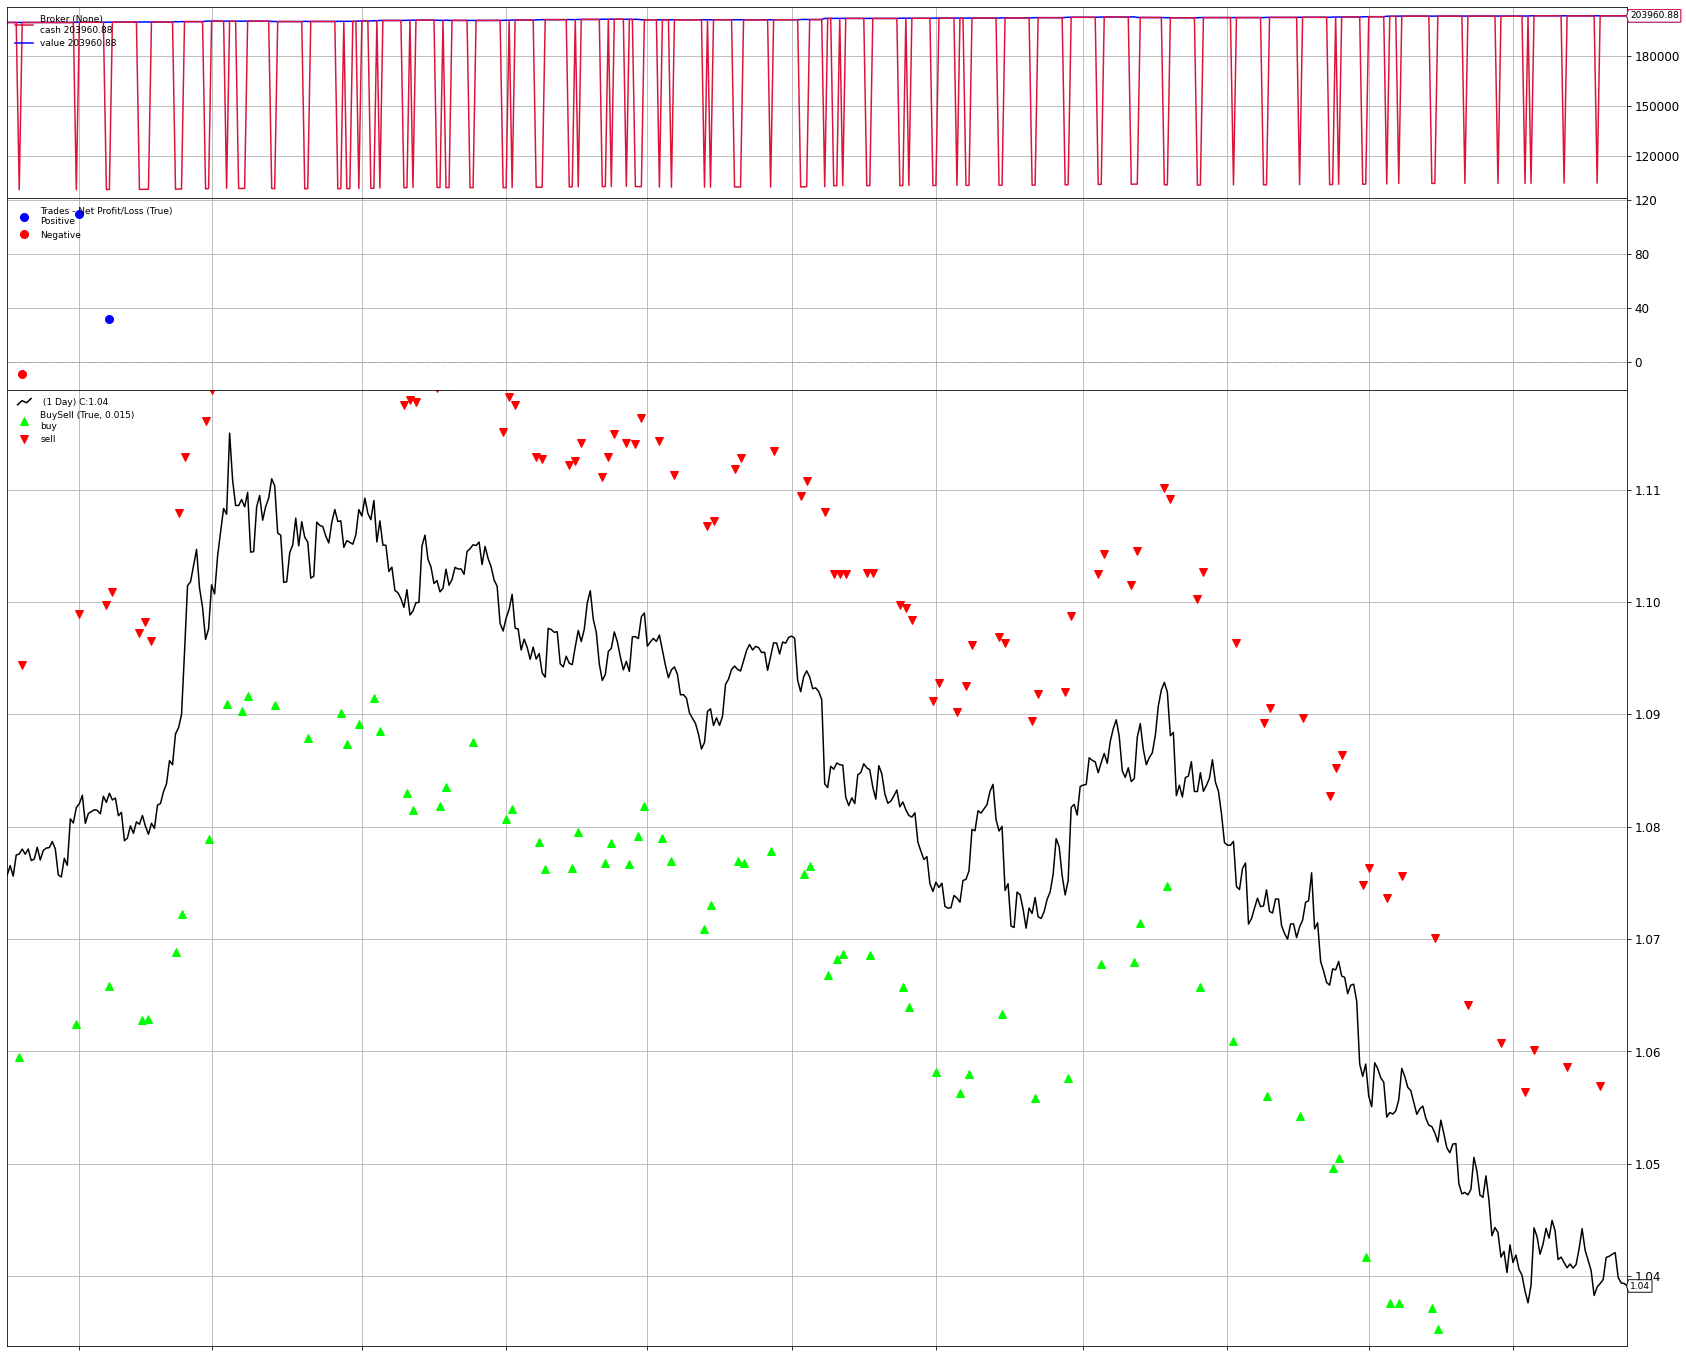

[[<Figure size 1800x1440 with 3 Axes>]]

In [189]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams.update({'font.size': 12})
cerebro.plot(volume=False, iplot = False)

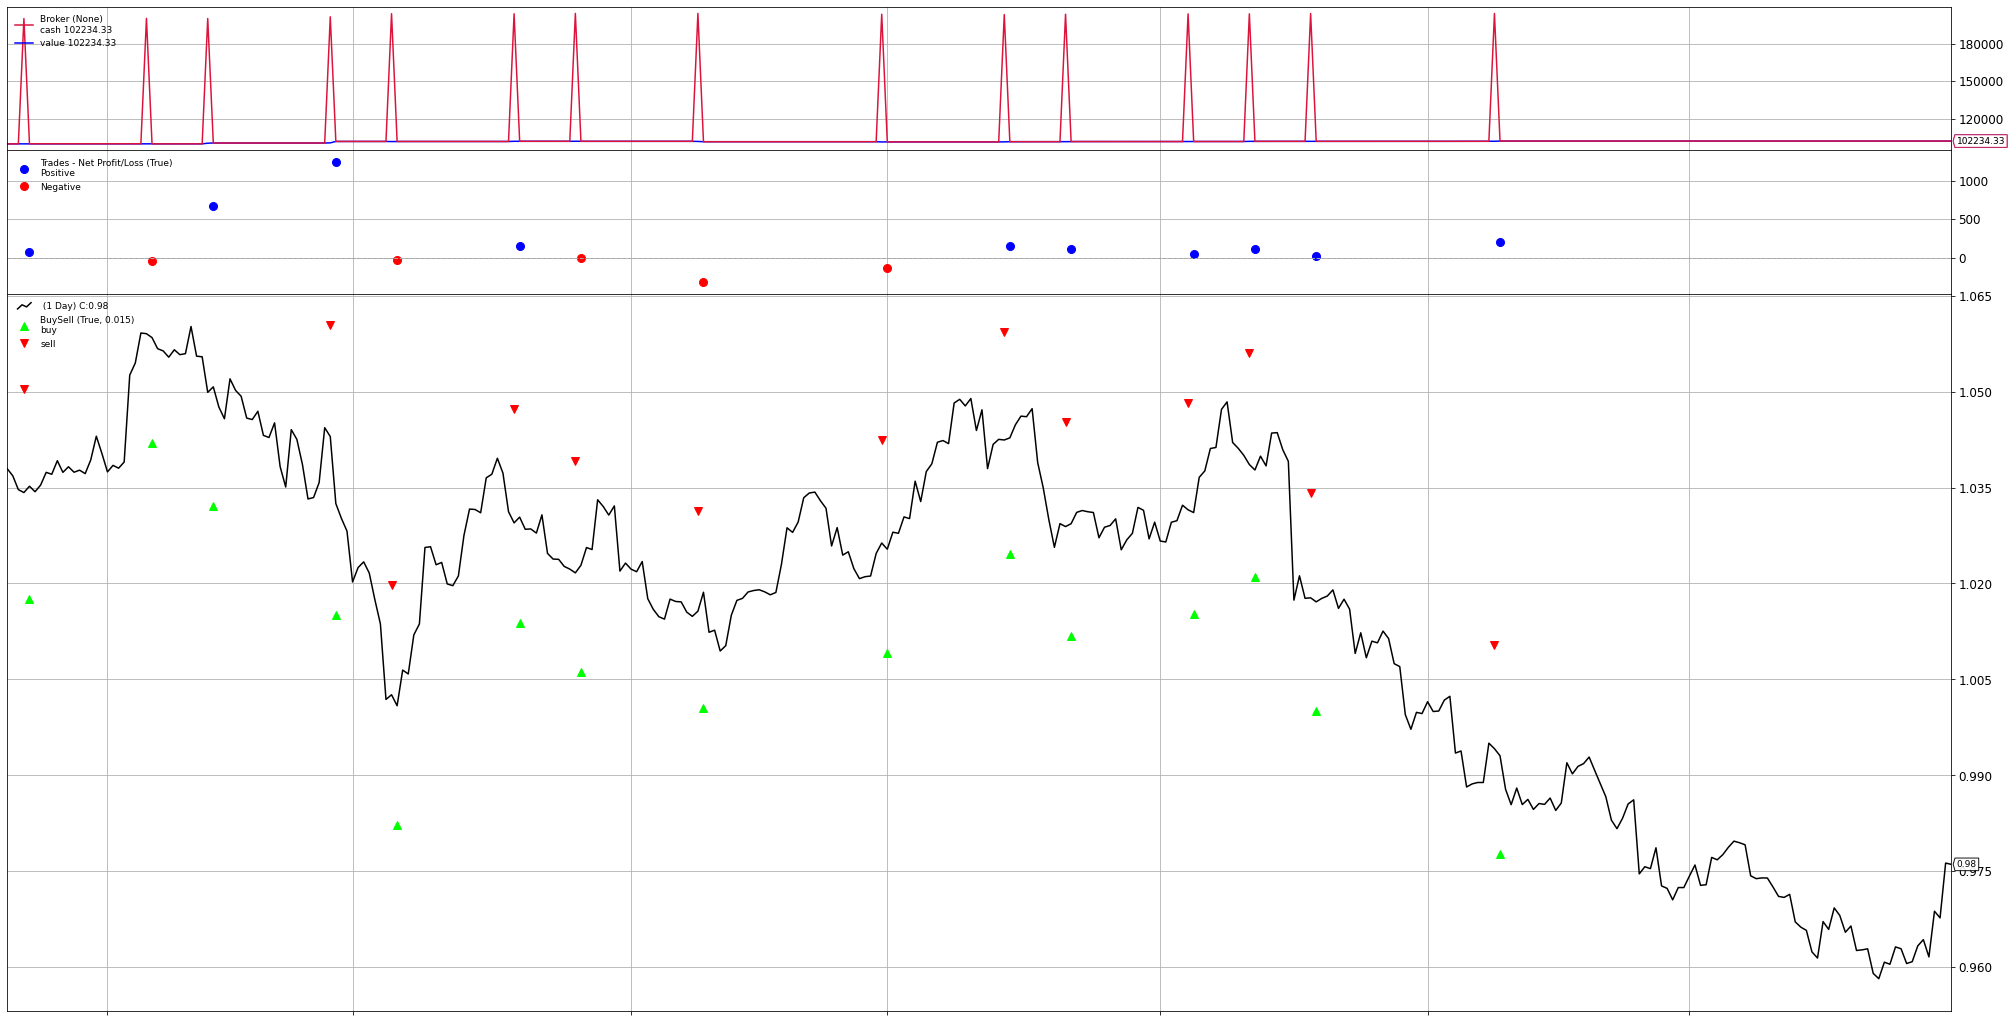

In [37]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 12})
figure = cerebro.plot(volume=False, iplot = False)[0][0]
figure.savefig('example.png')